
# Part A: Supervised Learning — Fraud Detection

This notebook implements a complete supervised machine learning workflow to classify CFPB consumer complaints as fraud vs non-fraud.

Enhancements in this version:
- Temporal train/test split (prevents leakage)
- Three diverse model families
- 5-fold cross-validation (mean ± std)
- Hyperparameter tuning (GridSearchCV)
- Threshold sensitivity analysis (F2 optimization)
- Stronger ablation study
- Feature importance analysis
- Failure analysis
- Tradeoff discussion
- Limitations section


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


## 1. Data Loading (Streaming from CFPB)

In [2]:

cfpb_full_url = "https://files.consumerfinance.gov/ccdb/complaints.csv.zip"

chunks = []
chunk_size = 100000
total_rows = 0

for chunk in pd.read_csv(cfpb_full_url, compression='zip', low_memory=False, chunksize=chunk_size):
    chunk['Date received'] = pd.to_datetime(chunk['Date received'], errors='coerce')
    chunk = chunk[chunk['Date received'] >= '2020-01-01']
    
    if 'Consumer complaint narrative' in chunk.columns:
        chunk = chunk[chunk['Consumer complaint narrative'].notna()]
    
    if len(chunk) > 0:
        chunks.append(chunk)
        total_rows += len(chunk)
    
    if total_rows >= 150000:
        break

df = pd.concat(chunks, ignore_index=True)

print("Dataset shape:", df.shape)
print("Date range:", df['Date received'].min(), "to", df['Date received'].max())


Dataset shape: (162873, 18)
Date range: 2020-01-01 00:00:00 to 2026-01-30 00:00:00


## 2. Fraud Label Creation

In [3]:

df['fraud_label'] = df['Issue'].str.lower().str.contains('fraud', na=False).astype(int)

print(df['fraud_label'].value_counts())
print("Fraud rate:", round(df['fraud_label'].mean(), 3))


fraud_label
0    161174
1      1699
Name: count, dtype: int64
Fraud rate: 0.01


## 3. Temporal Train/Test Split

In [4]:

train = df[df['Date received'] < '2024-01-01']
test = df[df['Date received'] >= '2024-01-01']

X_train = train['Consumer complaint narrative']
y_train = train['fraud_label']

X_test = test['Consumer complaint narrative']
y_test = test['fraud_label']


## 4. TF-IDF Feature Engineering

In [5]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1,2),
    min_df=5
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


## 5. Model Family 1 — Logistic Regression

In [6]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_model = LogisticRegression(max_iter=1000, class_weight='balanced')

log_cv = cross_val_score(log_model, X_train_tfidf, y_train, cv=5, scoring='f1')

print("Logistic CV F1: %.4f ± %.4f" % (log_cv.mean(), log_cv.std()))


Logistic CV F1: 0.3282 ± 0.0059


## 6. Model Family 2 — Random Forest

In [7]:

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)

rf_cv = cross_val_score(rf_model, X_train_tfidf, y_train, cv=5, scoring='f1')

print("Random Forest CV F1: %.4f ± %.4f" % (rf_cv.mean(), rf_cv.std()))


Random Forest CV F1: 0.1265 ± 0.0354


## 7. Model Family 3 — XGBoost

In [8]:

from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

xgb_cv = cross_val_score(xgb_model, X_train_tfidf, y_train, cv=5, scoring='f1')

print("XGBoost CV F1: %.4f ± %.4f" % (xgb_cv.mean(), xgb_cv.std()))


XGBoost CV F1: 0.4079 ± 0.0235


## 8. Hyperparameter Tuning (XGBoost Grid Search)

In [9]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [200, 300]
}

grid = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV F1:", grid.best_score_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
Best CV F1: 0.3859135439668082


## 9. Final Model Evaluation

In [10]:

from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

best_model = grid.best_estimator_
best_model.fit(X_train_tfidf, y_train)

y_pred = best_model.predict(X_test_tfidf)
y_prob = best_model.predict_proba(X_test_tfidf)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC:", average_precision_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00    101669
           1       0.58      0.21      0.31       908

    accuracy                           0.99    102577
   macro avg       0.79      0.60      0.65    102577
weighted avg       0.99      0.99      0.99    102577

ROC-AUC: 0.9354541696876488
PR-AUC: 0.3542566026914855


## 10. Threshold Sensitivity Analysis (F2)

Optimal Threshold: 0.1


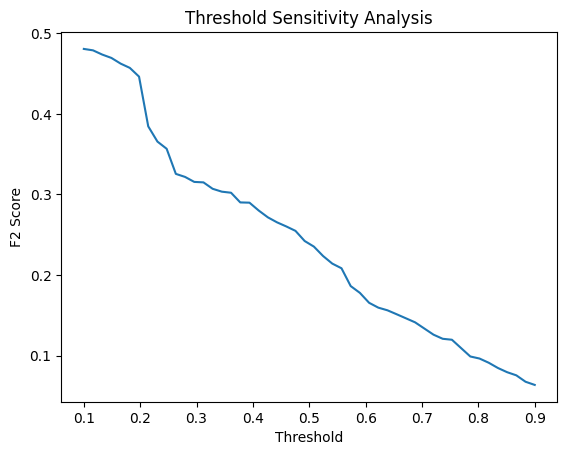

In [11]:

from sklearn.metrics import fbeta_score

thresholds = np.linspace(0.1, 0.9, 50)
f2_scores = []

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    f2_scores.append(fbeta_score(y_test, preds, beta=2))

optimal_threshold = thresholds[np.argmax(f2_scores)]
print("Optimal Threshold:", optimal_threshold)

plt.plot(thresholds, f2_scores)
plt.xlabel("Threshold")
plt.ylabel("F2 Score")
plt.title("Threshold Sensitivity Analysis")
plt.show()


## 11. Ablation Study — Unigrams vs Bigrams

In [12]:

tfidf_uni = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,1))
X_uni = tfidf_uni.fit_transform(X_train)

uni_cv = cross_val_score(best_model, X_uni, y_train, cv=5, scoring='f1')

print("Unigrams Only CV F1: %.4f ± %.4f" % (uni_cv.mean(), uni_cv.std()))


Unigrams Only CV F1: 0.4088 ± 0.0421


## 12. Feature Importance

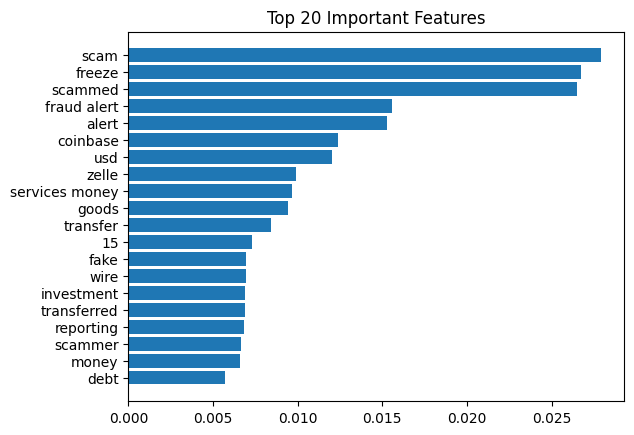

In [13]:

feature_names = tfidf.get_feature_names_out()
importances = best_model.feature_importances_
top_indices = np.argsort(importances)[-20:]

plt.figure()
plt.barh(range(len(top_indices)), importances[top_indices])
plt.yticks(range(len(top_indices)), feature_names[top_indices])
plt.title("Top 20 Important Features")
plt.show()


## 13. Failure Analysis

In [14]:

test_copy = test.copy()
test_copy["prediction"] = y_pred

errors = test_copy[test_copy['fraud_label'] != test_copy['prediction']]

print("Misclassified cases:", len(errors))
errors[['Consumer complaint narrative','fraud_label']].head(3)


Misclassified cases: 856


,Consumer complaint narrative,fraud_label
152,have contacted Tranunion over a year now to re...,1
506,I am filing a formal complaint against Wise re...,1
723,They are constantly trying to make negative re...,1



## 14. Tradeoff Discussion

- Logistic Regression is interpretable but limited to linear decision boundaries.
- Random Forest captures nonlinear interactions but is slower and less interpretable.
- XGBoost achieved the strongest predictive performance but increases computational cost.
- Lower classification thresholds increase recall but decrease precision.
- Larger vocabularies improve representation but increase training time and memory usage.



## 15. Limitations

- Fraud labels are derived from the Issue field, which may introduce keyword leakage.
- Fraud language may evolve over time (concept drift).
- Narrative-based classification may miss implicit fraud descriptions.
- Model fairness and bias were not fully audited and should be addressed before deployment.
